In [25]:
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import (
    DataStore,
    FixedPointingInfo,
    Observation,
    observatory_locations,
)
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling.models import (
    ExpDecayTemporalModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.catalog import CATALOG_REGISTRY

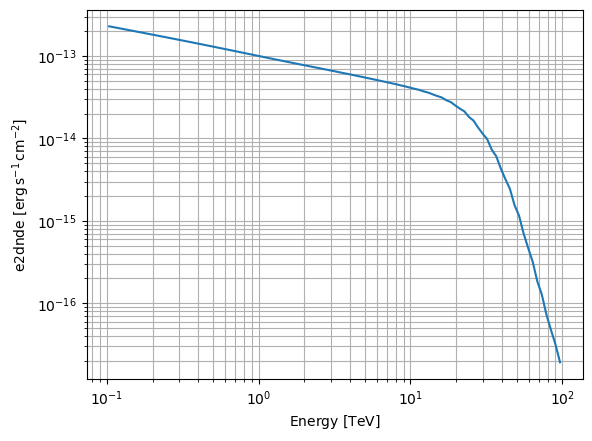

In [26]:
# Source
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
source_4fgl = catalog_4fgl["4FGL J0242.6-0000"]          # NGC 1068
fermi_model = source_4fgl.sky_model()

# Specify the redshift of the source
redshift = 0.00379

# Load the EBL model. Here we use the model from Dominguez, 2011
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

# The Fermi model is multiplied by the EBL to get the final model
spectral_model = fermi_model.spectral_model * ebl 

spatial_model = PointSpatialModel.from_position(target_position)

sky_model = SkyModel(
                    spectral_model=spectral_model,
#                    spatial_model=spatial_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Plotting the model
energy_bounds = [0.1, 100] * u.TeV
opts = dict(sed_type="e2dnde", yunits=u.Unit("erg cm-2 s-1"))
spectral_model.plot(energy_bounds, **opts)
plt.grid(which="both")

In [27]:
# Define the full model
models = Models([sky_model, bkg_model])
print(models)

# save it to disk
file_model = "./Fermi_NGC_1068.yaml"
models.write(file_model, write_covariance=False, overwrite=True)

irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

# this is a dictionary with the IRF extensions:
IRF

Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.350   +/-    0.05             
    amplitude                     :   6.49e-13   +/- 4.3e-14 1 / (MeV s cm2)
    reference             (frozen):   1048.521       MeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.004                   
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.0

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x17f999a50>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x16bdf3ad0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x16bdd7d10>,
 'bkg': <gammapy.irf.background.Background3D at 0x155317350>}

In [28]:
livetime = 85 * u.hr              #observation time with units
obs_id = "0001"                   # obs_id could be everything

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
)

location = observatory_locations["cta_north"]

reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")
observation = Observation.create(
                        obs_id=obs_id, 
                        pointing=pointing, 
                        livetime=livetime, 
                        irfs=IRF,
                        location=location,
                        reference_time = reference_time, 
                        tstart = 30 * u.min
              )                                   
print(observation)

Observation

	obs id            : 0001 
 	tstart            : 61188.02
	tstop             : 61191.56
	duration          : 306000.00 s
	pointing (icrs)   : 40.2 deg, -0.0 deg

	deadtime fraction : 0.0%



In [29]:
#Ereco ed Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of
#the whole photon energy extension)

energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" #If node_type = ‘edge’ then bounds correspond to the lower
                                                      #  and upper bound of the first and last bin.
    )    

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    #in reco energy
)
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(200), np.int64(200), 30)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 40.2 deg, -0.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 40.2 deg, -0.0 deg



In [30]:
#### MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       #for the IRF maps
        migra_axis=migra_axis,                   #for the Edisp map
        name="my-dataset",                       #the name that will read the FoVBKG
            )

### Make maps for a single observation
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) #which maps to make (by default all)
dataset = maker.run(empty, observation)    #object

dataset.models = models

print(dataset)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 4212779.02
  Total excess counts             : -4212779.02

  Predicted counts                : 4213532.52
  Predicted background counts     : 4212779.02
  Predicted excess counts         : 753.51

  Exposure min                    : 2.67e+06 m2 s
  Exposure max                    : 5.12e+11 m2 s

  Number of total bins            : 1200000 
  Number of fit bins              : 1200000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8427065.05

  Number of models                : 2 
  Number of parameters            : 10
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : NGC_1068
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:

In [31]:
#define the seed of random number generator 
seed=0

#simulate
sampler = MapDatasetEventSampler(random_state=seed)
events = sampler.run(dataset, observation)

The meta information will be empty here.


In [32]:
events.table

TIME,ENERGY_TRUE,RA_TRUE,DEC_TRUE,ENERGY,RA,DEC,MC_ID,EVENT_ID,DETX,DETY
s,TeV,deg,deg,TeV,deg,deg,,,deg,deg
float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64
1799.9999999999984,0.10869709435548203,40.66350275744929,0.07466161436349703,0.10869709435548203,40.66350275744929,0.07466161436349703,0,3287861,0.4945029163812189,0.08766113018782153
1799.9999999999984,0.1302528257048123,39.425988406709024,-1.4074944920579557,0.1302528257048123,39.425988406709024,-1.4074944920579557,0,1891514,-0.7430074703846608,-1.3944955851349963
1799.9999999999984,0.13555866950254883,38.62730676454091,0.42358453267466195,0.13555866950254883,38.62730676454091,0.42358453267466195,0,1409582,-1.5416958609082827,0.43657982681948065
1799.9999999999984,3.9043486623406958,41.15868164036233,-0.0010456511609445618,3.9043486623406958,41.15868164036233,-0.0010456511609445618,0,3178199,0.9896816617339653,0.011952409524188742
1800.028914243091,1.5589366022894438,41.61909591327336,0.9933154474170025,1.5589366022894438,41.61909591327336,0.9933154474170025,0,621026,1.4501016546010583,1.0063112840942248
1800.036805409859,0.10693602395834428,40.35909174778857,-1.040181208601241,0.10693602395834428,40.35909174778857,-1.040181208601241,0,2424229,0.1900909695846344,-1.0271812801484075
1800.262727495065,0.1927159045792232,39.403889144883685,1.589468955688465,0.1927159045792232,39.403889144883685,1.589468955688465,0,187959,-0.7651156917983777,1.602467796609279
1800.3590434900175,0.10528087787348175,41.84285072751182,-0.4199832807700688,0.10528087787348175,41.84285072751182,-0.4199832807700688,0,4183086,1.6738479870668446,-0.4069888279204498


In [33]:
print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 758
Background events: 4217324


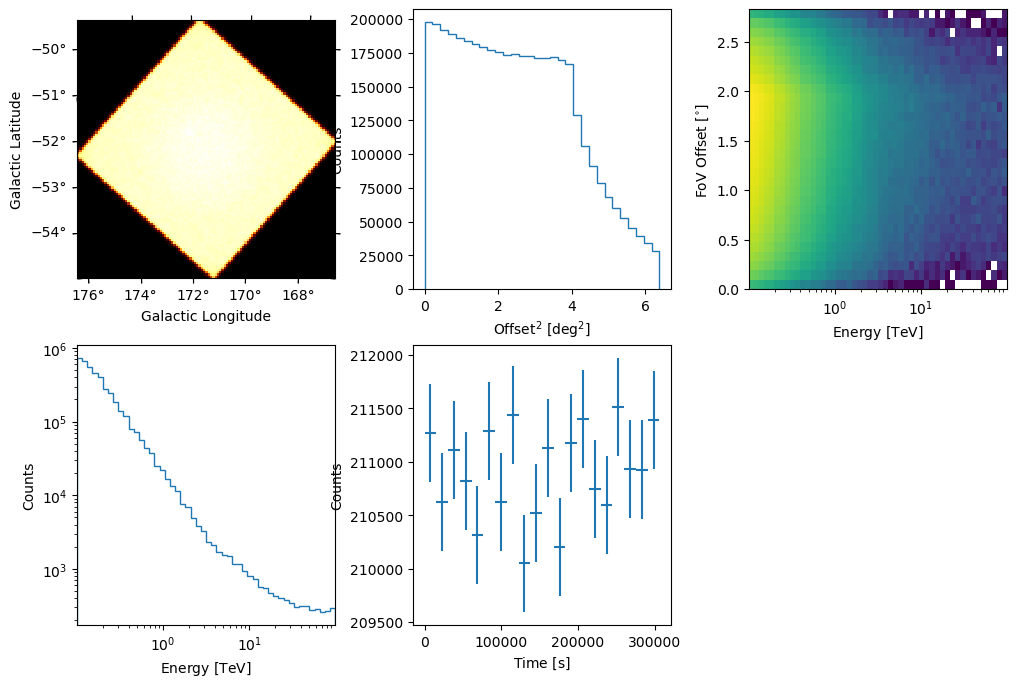

In [34]:
# let's have a look at the events
events.peek()
#counts map

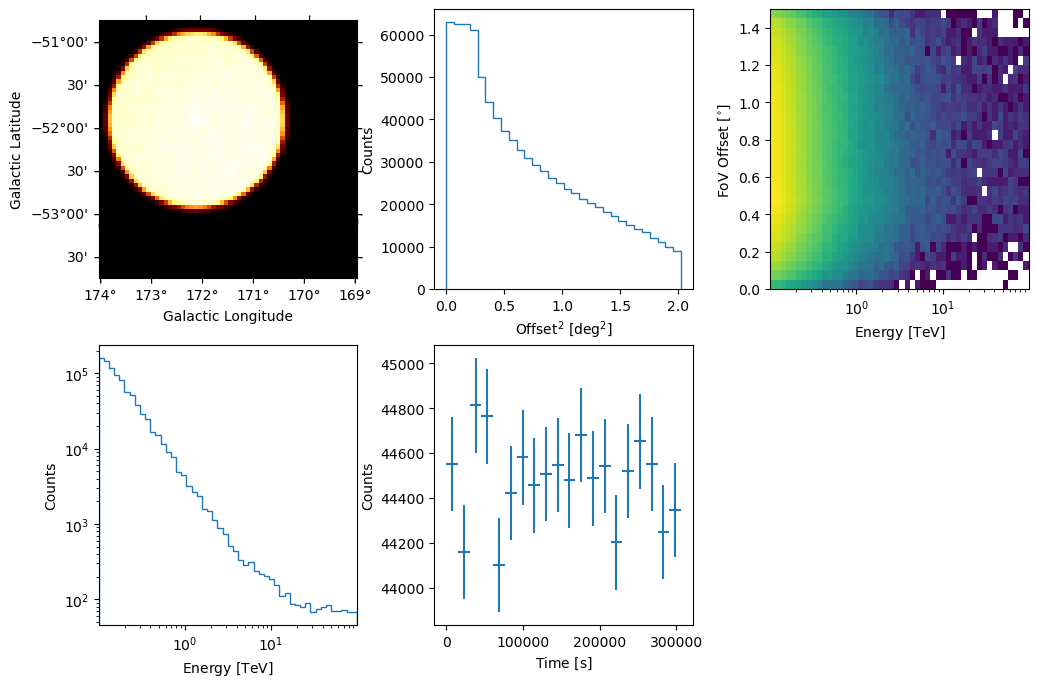

In [35]:
#We are focusing on our source
src_pos = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

#region_sky = CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)
region_sky = CircleSkyRegion(center=src_pos, radius=1 * u.deg)
evt = events.select_region(region_sky)
evt.peek()

In [36]:
# save the data into a fits file 
observation.events = events
observation.write("source_evt.fits", include_irfs=False, overwrite=True)